- 본 코드는 ImageNet1k 데이터 일부를 ResNet Pretrained 모델에서 DyT로 대체하는 Experiment를 수행합니다
1. ResNet의 BatchNormalization을 그대로 사용하여 학습
2. DyT로 대체하여 학습

## Batch Normalization

In [1]:
'''
pip install datasets
pip install timm

'''
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import time
from datasets import load_dataset
from PIL import Image
import pandas as pd

# HuggingFace에서 mini-ImageNet 로드
dataset = load_dataset("timm/mini-imagenet")

# 사용자 정의 Dataset 클래스
class HuggingfaceMiniImageNet(Dataset):
    def __init__(self, hf_split, transform=None):
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


def get_mini_imagenet_loaders(batch_size=128, num_workers=4):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = HuggingfaceMiniImageNet(dataset['train'], transform=train_transform)
    val_dataset = HuggingfaceMiniImageNet(dataset['validation'], transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader


def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total


def train_resnet50_mini_imagenet():
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_mini_imagenet_loaders()

    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 100)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    # 결과 저장용 리스트
    losses = []
    val_accuracies = []
    epoch_times = []

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start = time.time()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        val_acc = evaluate(model, val_loader, device)

        epoch_time = time.time() - start
        avg_loss = running_loss / len(train_loader)
        
        # 결과 저장
        losses.append(avg_loss)
        val_accuracies.append(val_acc)
        epoch_times.append(epoch_time)

        print(f"[BN] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

    torch.save(model.state_dict(), "resnet50_bn_mini_imagenet.pth")

    print_training_summary(losses, val_accuracies, epoch_times)


# 학습 후 결과 정리
def print_training_summary(losses, val_accuracies, epoch_times):
    df = pd.DataFrame({
        'Epoch': list(range(1, len(losses)+1)),
        'Loss': losses,
        'Val_Accuracy (%)': val_accuracies,
        'Time (s)': epoch_times
    })
    print("\n📊 Training Summary:")
    print(df.to_string(index=False))

    # (선택) CSV로 저장하고 싶다면
    df.to_csv("resnet50_bn_summary.csv", index=False)

if __name__ == '__main__':
    train_resnet50_mini_imagenet()
    

/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 1/30, Loss: 2.6713, Val Acc: 58.13%, Time: 256.37s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 2/30, Loss: 2.1828, Val Acc: 69.96%, Time: 125.68s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 3/30, Loss: 2.0345, Val Acc: 76.07%, Time: 128.62s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 4/30, Loss: 1.9478, Val Acc: 76.14%, Time: 126.18s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 5/30, Loss: 1.8857, Val Acc: 76.10%, Time: 128.01s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 6/30, Loss: 1.8239, Val Acc: 78.48%, Time: 126.52s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 7/30, Loss: 1.7917, Val Acc: 76.88%, Time: 127.59s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 8/30, Loss: 1.7374, Val Acc: 78.86%, Time: 126.12s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 9/30, Loss: 1.7018, Val Acc: 80.80%, Time: 126.61s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 10/30, Loss: 1.6765, Val Acc: 81.29%, Time: 126.03s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 11/30, Loss: 1.6276, Val Acc: 83.89%, Time: 126.70s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 12/30, Loss: 1.5909, Val Acc: 81.34%, Time: 125.89s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 13/30, Loss: 1.5568, Val Acc: 84.30%, Time: 126.17s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 14/30, Loss: 1.5236, Val Acc: 84.36%, Time: 126.71s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 15/30, Loss: 1.4912, Val Acc: 84.84%, Time: 126.56s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 16/30, Loss: 1.4525, Val Acc: 84.29%, Time: 126.08s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 17/30, Loss: 1.4249, Val Acc: 86.43%, Time: 128.17s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 18/30, Loss: 1.3925, Val Acc: 87.46%, Time: 126.59s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 19/30, Loss: 1.3619, Val Acc: 87.56%, Time: 126.10s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 20/30, Loss: 1.3292, Val Acc: 87.38%, Time: 127.17s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 21/30, Loss: 1.3009, Val Acc: 88.03%, Time: 126.89s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 22/30, Loss: 1.2765, Val Acc: 88.64%, Time: 126.60s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 23/30, Loss: 1.2545, Val Acc: 89.14%, Time: 126.28s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 24/30, Loss: 1.2223, Val Acc: 89.15%, Time: 126.16s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 25/30, Loss: 1.2102, Val Acc: 89.18%, Time: 126.27s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 26/30, Loss: 1.1915, Val Acc: 89.82%, Time: 126.51s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 27/30, Loss: 1.1810, Val Acc: 89.94%, Time: 126.35s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 28/30, Loss: 1.1775, Val Acc: 89.91%, Time: 126.25s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 29/30, Loss: 1.1645, Val Acc: 90.00%, Time: 127.20s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 30/30, Loss: 1.1670, Val Acc: 89.97%, Time: 126.69s

📊 Training Summary:
 Epoch     Loss  Val_Accuracy (%)   Time (s)
     1 2.671263             58.13 256.367543
     2 2.182777             69.96 125.680711
     3 2.034466             76.07 128.615551
     4 1.947797             76.14 126.176975
     5 1.885672             76.10 128.006634
     6 1.823860             78.48 126.521043
     7 1.791731             76.88 127.587235
     8 1.737398             78.86 126.124740
     9 1.701767             80.80 126.612518
    10 1.676503             81.29 126.034242
    11 1.627618             83.89 126.700036
    12 1.590911             81.34 125.892450
    13 1.556840             84.30 126.173824
    14 1.523603             84.36 126.706618
    15 1.491157             84.84 126.560447
    16 1.452528             84.29 126.075529
    17 1.424925             86.43 128.169347
    18 1.392491             87.46 126.589148
    19 1.361884             87.56 126.098277
    20 1.329158 

## DyT

In [ ]:
# pip install datasets timm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import time
from datasets import load_dataset
from PIL import Image
import pandas as pd

# DyT 정의
class DyT(nn.Module):
    def __init__(self, num_features, alpha_init=1.0):
        super(DyT, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha_init))
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return torch.tanh(self.alpha * x) * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)

# BN -> DyT 대체 함수
def replace_bn_with_dyt(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            num_features = module.num_features
            device = next(module.parameters()).device
            setattr(model, name, DyT(num_features).to(device))
        else:
            replace_bn_with_dyt(module)
    return model

# HuggingFace에서 mini-ImageNet 로드
dataset = load_dataset("timm/mini-imagenet")

class HuggingfaceMiniImageNet(Dataset):
    def __init__(self, hf_split, transform=None):
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def get_mini_imagenet_loaders(batch_size=128, num_workers=4):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = HuggingfaceMiniImageNet(dataset['train'], transform=train_transform)
    val_dataset = HuggingfaceMiniImageNet(dataset['validation'], transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total

def extract_alpha_values(model):
    alpha_values = []
    for i, module in enumerate(model.modules()):
        if isinstance(module, DyT):
            alpha_values.append(module.alpha.item())
    return alpha_values

def train_resnet50_dyt_mini_imagenet():
    device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_mini_imagenet_loaders()

    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 100)
    model = model.to(device)
    model = replace_bn_with_dyt(model)

    dyt_params, other_params = [], []
    for name, param in model.named_parameters():
        if 'alpha' in name or 'bias' in name:
            dyt_params.append(param)
        else:
            other_params.append(param)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD([
        {'params': dyt_params, 'weight_decay': 0.0},
        {'params': other_params, 'weight_decay': 0.0001},
    ], lr=0.05, momentum=0.9)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    num_epochs = 30
    losses, val_accuracies, alpha_history = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start = time.time()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate(model, val_loader, device)

        # 저장
        losses.append(avg_loss)
        val_accuracies.append(val_acc)
        alpha_values = extract_alpha_values(model)
        alpha_history.append(alpha_values)

        print(f"[DyT] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {time.time()-start:.2f}s")

    torch.save(model.state_dict(), "resnet50_dyt_mini_imagenet_final.pth")

    # 시각화용 저장
    df_main = pd.DataFrame({
        'Epoch': list(range(1, num_epochs + 1)),
        'Loss': losses,
        'Val_Acc': val_accuracies
    })
    df_main.to_csv("training_curve_dyt.csv", index=False)

    df_alpha = pd.DataFrame(alpha_history)
    df_alpha.columns = [f"alpha_{i}" for i in range(df_alpha.shape[1])]
    df_alpha["Epoch"] = list(range(1, num_epochs + 1))
    df_alpha.to_csv("alpha_history_dyt.csv", index=False)


if __name__ == '__main__':
    train_resnet50_dyt_mini_imagenet()


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 1/30, Loss: 4.5339, Val Acc: 7.49%, Time: 180.39s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 2/30, Loss: 4.1964, Val Acc: 13.15%, Time: 178.90s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 3/30, Loss: 3.8820, Val Acc: 23.88%, Time: 179.51s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 4/30, Loss: 3.5319, Val Acc: 33.88%, Time: 179.82s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 5/30, Loss: 3.1685, Val Acc: 43.16%, Time: 178.94s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 6/30, Loss: 2.9100, Val Acc: 50.89%, Time: 178.43s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 7/30, Loss: 2.7293, Val Acc: 57.01%, Time: 179.29s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 8/30, Loss: 2.5799, Val Acc: 60.34%, Time: 179.16s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 9/30, Loss: 2.4844, Val Acc: 63.17%, Time: 179.59s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 10/30, Loss: 2.3962, Val Acc: 66.01%, Time: 178.41s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 11/30, Loss: 2.3139, Val Acc: 67.19%, Time: 178.99s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 12/30, Loss: 2.2465, Val Acc: 69.49%, Time: 179.70s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 13/30, Loss: 2.1758, Val Acc: 71.54%, Time: 178.87s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 14/30, Loss: 2.1241, Val Acc: 73.14%, Time: 179.16s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 15/30, Loss: 2.0514, Val Acc: 74.67%, Time: 178.68s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 16/30, Loss: 1.9852, Val Acc: 75.99%, Time: 178.41s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 17/30, Loss: 1.9390, Val Acc: 75.97%, Time: 179.33s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 18/30, Loss: 1.8703, Val Acc: 77.58%, Time: 179.92s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 19/30, Loss: 1.8241, Val Acc: 78.74%, Time: 179.48s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 20/30, Loss: 1.7694, Val Acc: 80.11%, Time: 179.48s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 21/30, Loss: 1.7272, Val Acc: 81.31%, Time: 178.51s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 22/30, Loss: 1.6692, Val Acc: 82.12%, Time: 178.60s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 23/30, Loss: 1.6309, Val Acc: 82.74%, Time: 179.08s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 24/30, Loss: 1.5867, Val Acc: 83.33%, Time: 179.94s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 25/30, Loss: 1.5482, Val Acc: 84.70%, Time: 180.00s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 26/30, Loss: 1.5237, Val Acc: 84.34%, Time: 179.80s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 27/30, Loss: 1.4939, Val Acc: 84.78%, Time: 179.36s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 28/30, Loss: 1.4681, Val Acc: 85.33%, Time: 178.67s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 29/30, Loss: 1.4632, Val Acc: 85.39%, Time: 178.99s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 30/30, Loss: 1.4555, Val Acc: 85.38%, Time: 178.39s


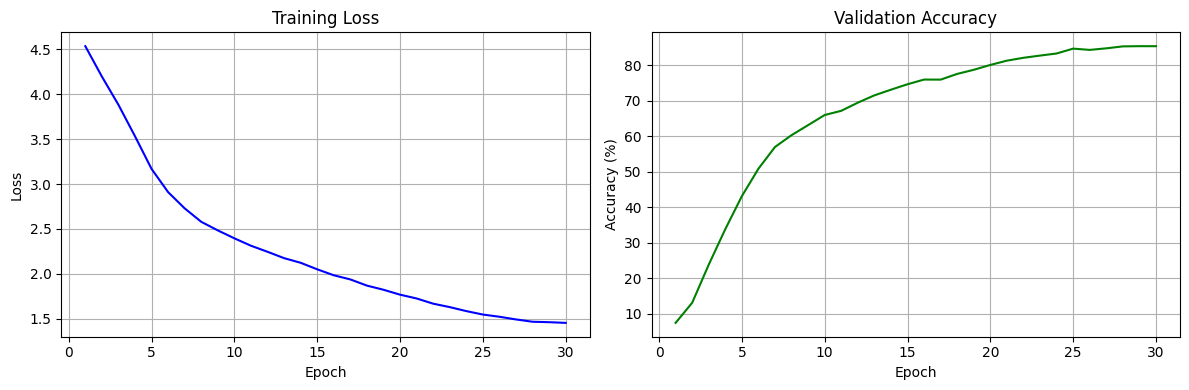

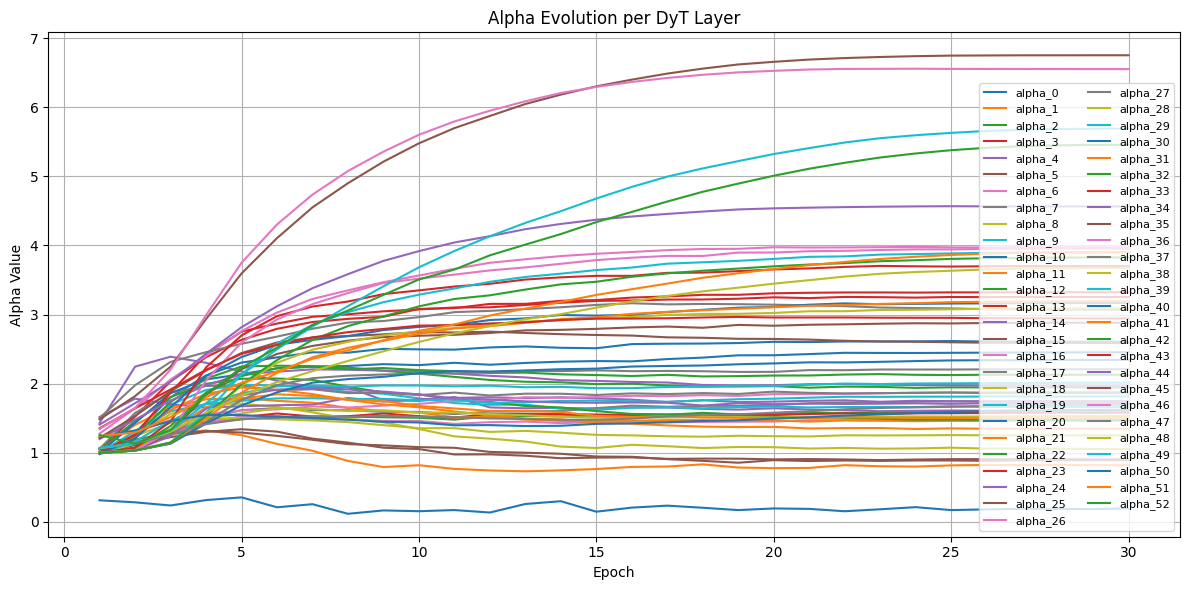

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로딩
df_main = pd.read_csv("training_curve_dyt.csv")
df_alpha = pd.read_csv("alpha_history_dyt.csv")

# 📈 Loss & Val Accuracy 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(df_main['Epoch'], df_main['Loss'], label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_main['Epoch'], df_main['Val_Acc'], label='Val Acc', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# 📉 Alpha 값 변화 시각화
plt.figure(figsize=(12, 6))
alpha_columns = [col for col in df_alpha.columns if col.startswith("alpha_")]

for col in alpha_columns:
    plt.plot(df_alpha['Epoch'], df_alpha[col], label=col)

plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.title('Alpha Evolution per DyT Layer')
plt.legend(fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
